[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Concepts/Python/Multiple%20Comparisons.ipynb)

# Definitions

The multiple comparisons problem in statistics occurs when multiple statistical inferences are done simultaneously, which greatly increases the probability that any one inference will yield an erroneous result, by chance. A lot has been written about this problem, including:

- [Its prevalence in fMRI data analysis](https://www.sciencedirect.com/science/article/pii/S1053811912007057?via%3Dihub) (including a compelling illustration by this [prizewinning study](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)\)

- [How Baysian methods can avoid the problem](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf).

- [General approaches for correcting for multiple comparisons](http://www.biostathandbook.com/multiplecomparisons.html).

Here we will provide some intuition for the problem using a simple thought experiment, to sensitize you to how much of a problem it can be. Consider performing the same statistical test on *N* different samples corresponding to, say, different voxels in fMRI data, using a *p*-value of $\alpha$ (typically 0.05) for each test.

Thus, for any one test, the probability of getting a Type I error (rejecting $H_0$ when $H_0$ is true) is $\alpha$:

$p_{error}=\alpha$

For two tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from either one:

$p_{error}=1-(1-\alpha)(1-\alpha)$

For *N* tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from any one:

$p_{error}=1-(1-\alpha)^N$

Run the cell below to see that the probability of getting a Type I error under these conditions grows rapidly with *N*, implying that it becomes very, very likely that you will get a "statistically significant result" just by chance if you do enough tests:

Text(0, 0.5, '$P_{error}$')

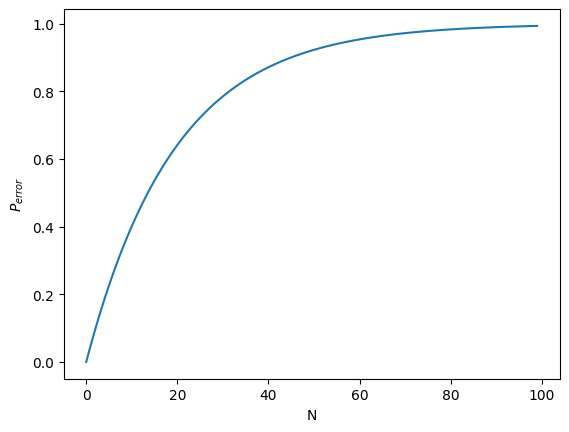

In [1]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('$P_{error}$')

# Correcting for multiple comparisons



There are a number of different methods that can be used to [correct for this problem](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/). Below are two common methods.




## Bonferroni correction

The simplest way to correct for Type I errors (false positives) in multiple comparisons is to divide $\alpha$ by the number of comparisons, known as the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html). This is a very conservative test that is typically used when the number of comparisons is relatively small and you want to avoid Type I errors.

## Benjamini–Hochberg procedure


Another approach is to more carefully control the false-discovery rate using the [Benjamini–Hochberg procedure](https://www.jstor.org/stable/2346101?seq=1#metadata_info_tab_contents):

1\. Rank the individual *p*-values in ascending order, labeled *i*=1...*n*

2\. For each *p*-value, calculate its "critical value" as (*i*/*n*)*Q*, where *i* is the rank, *n* is the total number of tests, and *Q* is the false discovery rate (a percentage) that you choose (typically 0.05).

3\. In your rank-ordered, original *p*-values, find the largest value that is smaller than its associated critical value; this *p*-value is the new criterion (i.e., reject $H_0$ for all cases for which *p* ≤ this value).

# Exercise

In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction.

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

Samples with equal Mean
Fraction of p-values < 0.05: 0.06
Number of Bonferroni-corrected significant p-values: 0
Number of Benjamini-Hochberg-corrected significant p-values: 0
Samples with different Mean, delta = 1
Fraction of p-values < 0.05: 1.0
Number of Bonferroni-corrected significant p-values: 996
Number of Benjamini-Hochberg-corrected significant p-values: 1000


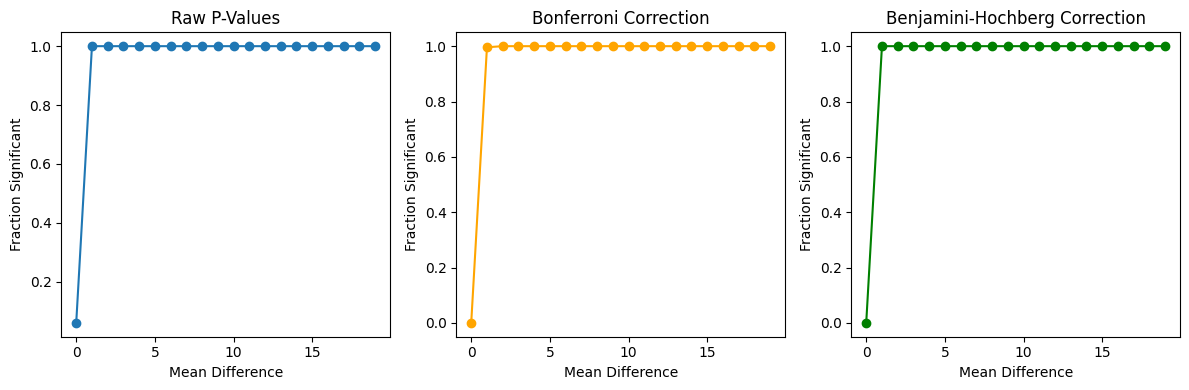

In [17]:
import numpy as np
from scipy import stats
# ANSI escape code for bold text
bold = "\033[1m"
# ANSI escape code for underlined text
underline = "\033[4m"
# ANSI escape code to reset text formatting
reset = "\033[0m"

#Function to perform the simulations and the p-value calculations, including the corrections
def perform_t_tests_and_corrections(mean1, mean2, num_tests=1000, alpha=0.05):
    # Set the random seed for reproducibility
    np.random.seed(42)

    # Initialize a list to store p-values
    p_values = []

    # Perform t-tests
    for _ in range(num_tests):
        # Generate two random samples with specified means and equal standard deviations
        sample1 = np.random.normal(loc=mean1, scale=1, size=100)
        sample2 = np.random.normal(loc=mean2, scale=1, size=100)

        # Perform a t-test and store the p-value
        _, p_value = stats.ttest_ind(sample1, sample2)
        p_values.append(p_value)

    # Calculate the fraction of p-values < 0.05
    num_total_tests = num_tests
    num_significant_p_values = sum(np.array(p_values) < alpha)
    fraction_significant = num_significant_p_values / num_total_tests

    # Apply the Bonferroni correction
    bonferroni_threshold = alpha / num_total_tests
    significant_p_values_bonferroni = sum(np.array(p_values) < bonferroni_threshold)

    # Sort the p-values for the Benjamini-Hochberg correction
    sorted_p_values = np.sort(p_values)

    # Apply the Benjamini-Hochberg correction
    thresholds_bh = alpha * (np.arange(1, num_total_tests + 1) / num_total_tests)
    significant_indices_bh = np.where(sorted_p_values <= thresholds_bh)[0]
    significant_p_values_bh = sorted_p_values[significant_indices_bh]

    return {
        "fraction_significant": fraction_significant,
        "significant_p_values_bonferroni": significant_p_values_bonferroni,
        "significant_p_values_bh": len(significant_p_values_bh),
    }

# Same means
results_same = perform_t_tests_and_corrections(mean1=1, mean2=1, num_tests=1000, alpha=0.05)
text = "Samples with equal Mean"
print(f"{bold}{underline}{text}{reset}")
del(text)
print("Fraction of p-values < 0.05:", results_same["fraction_significant"])
print("Number of Bonferroni-corrected significant p-values:", results_same["significant_p_values_bonferroni"])
print("Number of Benjamini-Hochberg-corrected significant p-values:", results_same["significant_p_values_bh"])

# Different means
results_diff = perform_t_tests_and_corrections(mean1=1, mean2=2, num_tests=1000, alpha=0.05)
text = "Samples with different Mean, delta = 1"
print(f"{bold}{underline}{text}{reset}")
del(text)
print("Fraction of p-values < 0.05:", results_diff["fraction_significant"])
print("Number of Bonferroni-corrected significant p-values:", results_diff["significant_p_values_bonferroni"])
print("Number of Benjamini-Hochberg-corrected significant p-values:", results_diff["significant_p_values_bh"])

# Different means increasing from 1 to 20
# Initialize lists to store results
mean_differences = []
fraction_significant_raw = []
fraction_significant_bonferroni = []
fraction_significant_bh = []

# Iterate over different mean differences
for mean_difference in range(0, 20):
    mean1 = 1
    mean2 = mean1 + mean_difference

    # Perform t-tests and corrections
    results = perform_t_tests_and_corrections(mean1, mean2, num_tests=1000, alpha=0.05)

    # Store the results
    mean_differences.append(mean_difference)
    fraction_significant_raw.append(results["fraction_significant"])
    fraction_significant_bonferroni.append(results["significant_p_values_bonferroni"] / 1000)
    fraction_significant_bh.append(results["significant_p_values_bh"] / 1000)

# Create subplots
plt.figure(figsize=(12, 4))

# Subplot 1: Raw p-values
plt.subplot(131)
plt.plot(mean_differences, fraction_significant_raw, marker='o')
plt.title('Raw P-Values')
plt.xlabel('Mean Difference')
plt.ylabel('Fraction Significant')

# Subplot 2: Bonferroni correction
plt.subplot(132)
plt.plot(mean_differences, fraction_significant_bonferroni, marker='o', color='orange')
plt.title('Bonferroni Correction')
plt.xlabel('Mean Difference')
plt.ylabel('Fraction Significant')

# Subplot 3: Benjamini-Hochberg correction
plt.subplot(133)
plt.plot(mean_differences, fraction_significant_bh, marker='o', color='green')
plt.title('Benjamini-Hochberg Correction')
plt.xlabel('Mean Difference')
plt.ylabel('Fraction Significant')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Additional Resources


How to correct for multiple comparisons in [Matlab](https://www.mathworks.com/help/stats/multcompare.html), [R](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/p.adjust.html), and [Python](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania